# Predicting Retweets of @realDonaldTrump Twitter account. 

## Abstract
Twitter is one of the most popular platforms for expressing opinions, thoughts and updates, but it is also used to influence people and is a "tactic" widely used in election campaigns. President Donald Trump's Twitter account is very popular, his tweet frequency is relatively high, and his tweets are liked and retweeted hundreds of thousands of times.

This notebook implements a regression model to predict the number of retweets of a particular tweet from @realdonaldtrump. Additionally the meaning of features is evaluated and compared.

The result of this notebook is, besides the prediction model, a set of important characteristics for a high number of retweets. These can be used to increase the retweet rate of candidates for future election campaigns. Our model can be used to decide on which parts to focus on when tweeting (length, specific hashtags, time of day, etc.) in order to maximize the number of retweets and gain popularity or even become viral.

## Data Selection

For the task of this notebook the Tweets and the Retweet counts of the @realdonaldtrump Twitter account are needed. This notebooks uses the data from http://trumptwitterarchive.com/archive. The data spans from Donald J. Trumps inauguration on January 20, 2017 until April 30, 2020. 

In [359]:
#import data from http://trumptwitterarchive.com/archive
import pandas as pd

twitterdata = pd.read_json("tweets_@donaldtrump_20170120_20200430.json")

## Data Exploration

Initial exploration of the dataset.  

In [360]:
#dimension of dataset
dimension_twitterdata = twitterdata.shape
print("The dataset has " + str(dimension_twitterdata[0]) + " records and " +
      str(dimension_twitterdata[1]) + " variables." )

The dataset has 13796 records and 5 variables.


In [361]:
#show the first 10 records of the dataset
print(twitterdata.head(10))

               source                                               text  \
0  Twitter for iPhone  No, I think Amash would make a wonderful candi...   
1  Twitter for iPhone  THANK YOU @MarkLevinShow! \nhttps://t.co/GJSNM...   
2  Twitter for iPhone  At least they admit it. The Failing @nytimes &...   
3  Twitter for iPhone  The only reason the U.S. has reported one mill...   
4  Twitter for iPhone  THANK YOU MICHAEL! @bittyandbeaus https://t.co...   
5  Twitter for iPhone    https://t.co/shcVSYZmuY https://t.co/ispKWWF96K   
6  Twitter for iPhone                            https://t.co/9YNWvhqCk7   
7  Twitter for iPhone  Thank you @BlueAngels and @AFThunderbirds! #Am...   
8  Twitter for iPhone  But I love Diamond &amp; Silk, and so do milli...   
9  Twitter for iPhone  Texas to open businesses in phases beginning F...   

                 created_at  retweet_count               id_str  
0 2020-04-29 14:55:22+00:00          14918  1255510996623527936  
1 2020-04-29 14:42:56+00:00    

In [362]:
#show variables and variables type
print(twitterdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13796 entries, 0 to 13795
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   source         13796 non-null  object             
 1   text           13796 non-null  object             
 2   created_at     13796 non-null  datetime64[ns, UTC]
 3   retweet_count  13796 non-null  int64              
 4   id_str         13796 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 539.0+ KB
None


The variables in the dataset are source, text, created_at, retweet_count, id_str.

Explanation of the variables. 
* **source** is the kind of device used for the tweet.
* **text** is content of the tweet.
* **created_at** is the timestamp of the tweet in UTC.
* **retweet_count** is number of retweets of the tweet.
* **id_str** is an unique identifier of the tweet.

### Missing data
It can already be seen, that there is no missing data.

### Duplicates

In [363]:
#check for duplicates
dublicated_entries = twitterdata.duplicated(keep = False)
print("There are " + str(dublicated_entries.sum()) + " duplicated entries.")

There are 0 duplicated entries.


In [364]:
#check for duplicate texts
dublicated_text = twitterdata.loc[:, ["text"]].duplicated(keep = False)
print("There are " + str(dublicated_text.sum()) + " duplicated text of tweets.")

There are 258 duplicated text of tweets.


In [365]:
#show tweets with duplicated text.
print(twitterdata[dublicated_text].sort_values(by='created_at').tail(10))

                 source                                               text  \
271  Twitter for iPhone  White House news conference at 5:30 P.M. Easte...   
235  Twitter for iPhone  So now the Fake News @nytimes is tracing the C...   
230  Twitter for iPhone  So now the Fake News @nytimes is tracing the C...   
222  Twitter for iPhone                                      HAPPY EASTER!   
121  Twitter for iPhone  I will be having a White House Press Conferenc...   
106  Twitter for iPhone  I will be having a White House Press Conferenc...   
95   Twitter for iPhone  I will be having a White House Press Conferenc...   
86   Twitter for iPhone  I will be having a White House Press Conferenc...   
55   Twitter for iPhone  I will be having a White House Press Conferenc...   
14   Twitter for iPhone  I will be having a White House Press Conferenc...   

                   created_at  retweet_count               id_str  
271 2020-04-08 20:37:12+00:00          13670  1247986878307078144  
235 2

There are a few dupplicated text, which will be analyzed further. It can be seen that there are text that are repeated, like "MAKE AMERICA GREAT AGAIN" which are not a problem. But on the other site there are text, which seem like they were deleted and reposted later. It is difficult to check which one them is a real retweet and which of them was deleted. Therefore it is out of scope in this project to delete the tweets.

### Check the target class retweet_count
The target class is the number of retweets of a tweet. This is represented in the data as integer (int64).

In [366]:
#maximum of the retweet value
print("The maximal retweet value is " + str(twitterdata.loc[:,'retweet_count'].max()) + "." )

The maximal retweet value is 369530.


Seems legitimate so far.

In [367]:
#minimum of the retweet value
print("The minimal retweet value is " + str(twitterdata.loc[:,'retweet_count'].min()) + "." )

The minimal retweet value is 0.


Seems like there is an outlier here. One hypothesis is that these are the tweets which are deleted and appear two times in the dataset. It cannot be finally confirmed, since we do not have a label for deleted tweets and not every tweet, which was deleted is tweeted again later. If you go back to the site http://www.trumptwitterarchive.com/archive you can see that every tweet here is not availabe anymore. It was probably posted and shortly after deleted. For example one tweet has 0 retweets, which is deleted. But Trump posted the exact same tweet one minute after this tweet and it got 8000 retweets: https://twitter.com/realdonaldtrump/status/1235034836705959936.

In [368]:
#other summary statistics
twitterdata.loc[:,'retweet_count'].describe()

count     13796.000000
mean      19321.801392
std       12886.352610
min           0.000000
25%       11940.750000
50%       17183.000000
75%       23882.000000
max      369530.000000
Name: retweet_count, dtype: float64

So far so good it looks like there is an skewed distribution of the values.

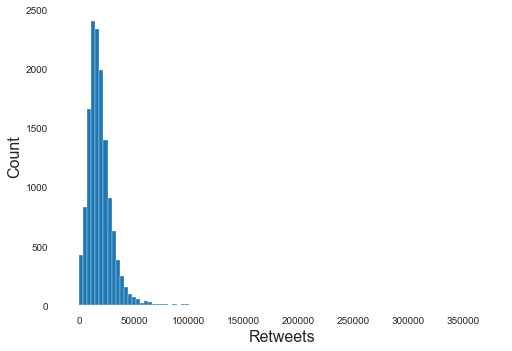

In [369]:
#visualize the retweet frequenzy as histogramm
import matplotlib.pyplot as plt
plt.hist(twitterdata["retweet_count"], bins = 100)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

It can be seen that there is an highly skewed distribution with an long tail. First visual impression shows an one sided truncated normal distribution.

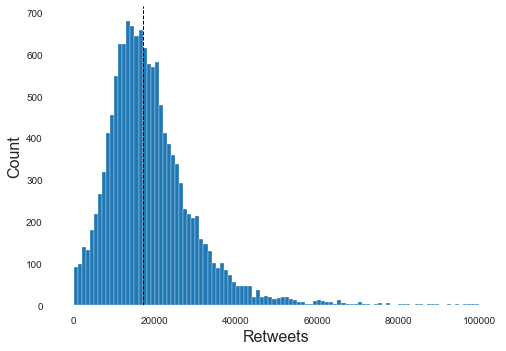

In [370]:
#visualize the retweet frequenzy as histogramm for retweet_count < 100.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] < 100000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100)
plt.axvline(twitterdata_truncated.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

Seems like the inital hypothesis is confirmed.

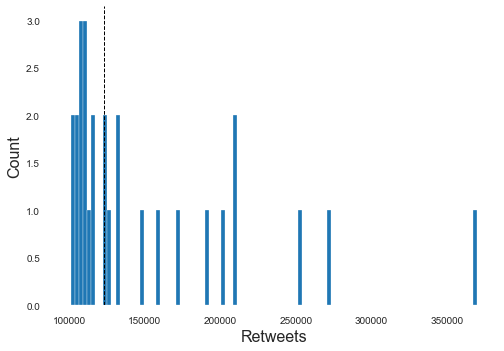

In [371]:
#visualize the retweet frequenzy as histogramm for retweet_count > 100.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] > 100000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100)
plt.axvline(twitterdata_truncated.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

There seems nothing wrong here.

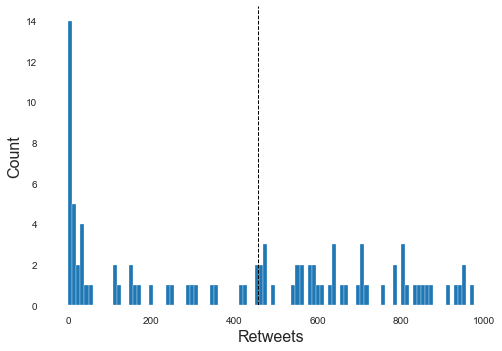

In [372]:
#visualize the retweet frequenzy as histogramm for retweet_count < 1.000
twitterdata_truncated = twitterdata[twitterdata["retweet_count"] < 1000].loc[:, "retweet_count"]
plt.hist(twitterdata_truncated, bins = 100)
plt.axvline(twitterdata_truncated.median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Retweets', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

Seems like there especially many tweets that have retweet count 0. These will most likely be deleted tweets. The rest could also be deleted tweets.

The first analysis of the retweet count shows that the data is so far so good. The only problem are the potentially deleted tweet, which cannot be analyzed in this first project.

### Check the attribute source
This is represented in the data as strings (object).

In [373]:
#check how many distinct values there are. 
twitterdata_source_unique = twitterdata.loc[:,'source'].unique()
print("There are " + str(twitterdata_source_unique .size) + " distinct values.")

There are 8 distinct values.


In [374]:
#show the different values
print("The different values are:")
print(twitterdata_source_unique)

The different values are:
['Twitter for iPhone' 'Twitter Media Studio' 'Twitter Web App'
 'Twitter Web Client' 'Twitter for iPad' 'Media Studio' 'Twitter Ads'
 'Twitter for Android']


In [375]:
#show the frequency of the different values
twitterdata_source_frequency = twitterdata.groupby(by = "source").count().loc[:,"retweet_count"]
print(twitterdata_source_frequency)

source
Media Studio              155
Twitter Ads                33
Twitter Media Studio      164
Twitter Web App             4
Twitter Web Client         48
Twitter for Android       173
Twitter for iPad           35
Twitter for iPhone      13184
Name: retweet_count, dtype: int64


It can be seen that there are very infrequent classes. It has to be seen, if these should be binned into on class or if they have prediction power. Therefore the next step is to analyze the retweet count based on the source.

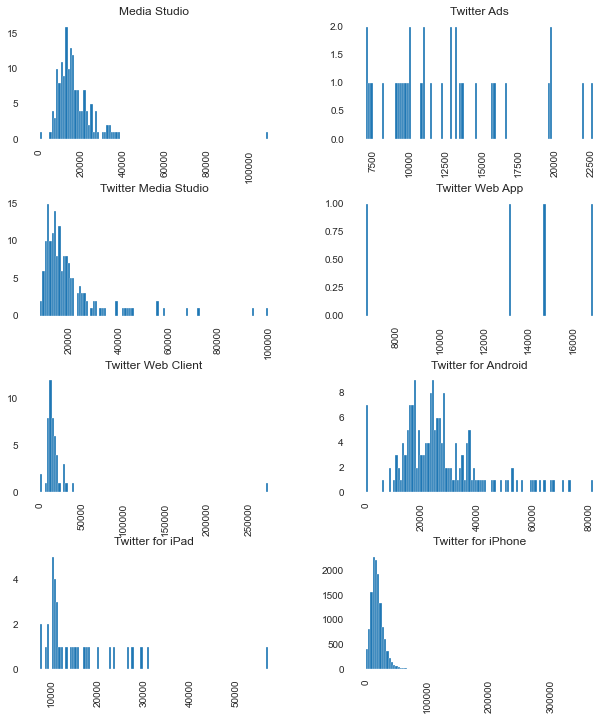

In [376]:
#visualize retweet count based on source
twitterdata_source_hist = twitterdata.hist(column='retweet_count', by='source', bins=100, grid=False, figsize=(10,12), layout=(4,2))

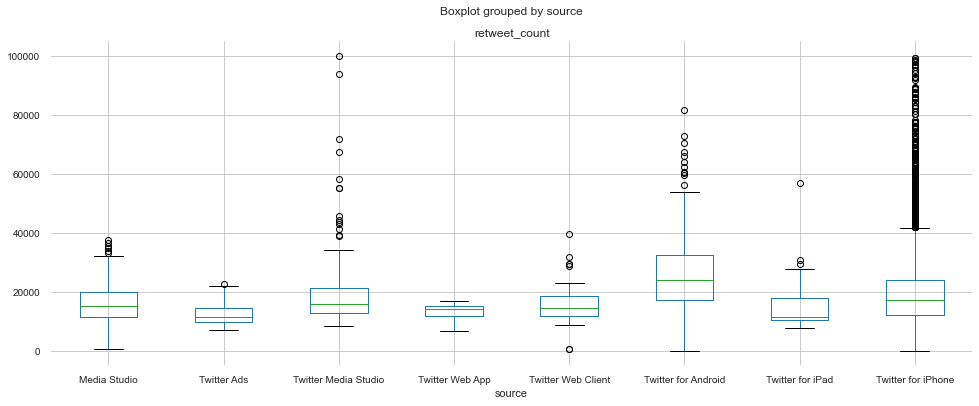

In [377]:
#use boxplots for more clear results
twitterdata_source_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='source', figsize = (16,6))

Seems like there are differences. Binn the most infrequent values to show more significant results. 

In [378]:
#bin values
twitterdata['source_binned'] = twitterdata["source"].replace({'Media Studio': 'Video', 'Twitter Media Studio': 'Video',
                                                              'Twitter Ads' : "others", 'Twitter Web App' : 'others',
                                                              'Twitter Web Client' : 'others', 'Twitter for iPad' : 'others'
                                                             }).astype('category').cat.codes

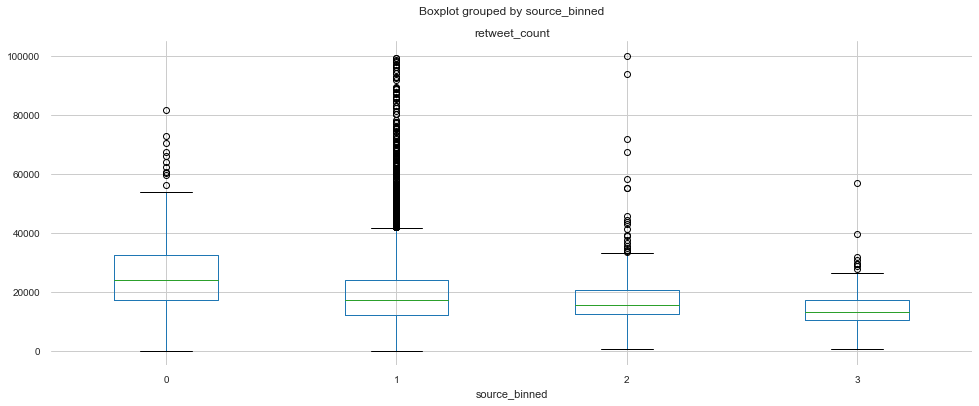

In [379]:
#visualy compare the two categories
twitterdata_source_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='source_binned', figsize = (16,6))

That looks more promising.

In [380]:
twitterdata = twitterdata.drop("source", axis=1)

### Check the attribute created_at
This is represented in the data as time (datetime64[ns, UTC]).

In [381]:
#check the basis statistics
twitterdata.loc[:,'created_at'].describe()

count                         13796
unique                        13411
top       2019-06-09 12:26:37+00:00
freq                              4
first     2017-01-20 00:40:51+00:00
last      2020-04-29 14:55:22+00:00
Name: created_at, dtype: object

The data range is the targeted. What is noticable that there non unique values. These are further investigated. 

In [382]:
#show tweets with duplicated dates.
dublicated_text = twitterdata.loc[:, ["created_at"]].duplicated(keep = False)
print("There are " + str(dublicated_text.sum()) + " duplicated dates of tweets.")

There are 733 duplicated dates of tweets.


In [383]:
#check for duplicate texts
print(twitterdata[dublicated_text].sort_values(by='created_at').head(6))

                                                    text  \
13184             Big win in Montana for Republicans! We   
13183  Just arrived in Italy after having a very succ...   
11014  Looks like Jerry Brown and California are not ...   
11015  So many people are seeing the benefits of the ...   
11009  Today’s Court decision means that Congress mus...   
11010  ....Congress – House and Senate must quickly p...   

                     created_at  retweet_count              id_str  \
13184 2017-05-28 11:57:20+00:00            428  868798339676086272   
13183 2017-05-28 11:57:20+00:00            416  868798339671830528   
11014 2018-04-17 12:24:36+00:00          15332  986218870506754048   
11015 2018-04-17 12:24:36+00:00          15379  986218871991492608   
11009 2018-04-17 21:34:23+00:00          15804  986357228306354176   
11010 2018-04-17 21:34:23+00:00          13120  986357230219022336   

       source_binned  
13184              1  
13183              1  
11014              

Seems like there is no fixable mistake with the duplicated dates.

Since the data is in UTC +00, it needs to be changed eastern time zone, washington -5.

In [384]:
#change timezone 
twitterdata['created_at_utc'] = twitterdata['created_at']
twitterdata['created_at'] = pd.DatetimeIndex(twitterdata['created_at']).tz_convert('America/New_York')

It is the best guess to change the time to Washington time zone. If he is in other time zones it can not be seen. It also does not necessary have an real impact, since the time difference remains the same. 

In [385]:
#create hour of the day and date as attributes
twitterdata['created_at_hour'] = twitterdata["created_at"].dt.hour.astype('category').cat.codes
twitterdata['created_at_date'] = twitterdata["created_at"].dt.date

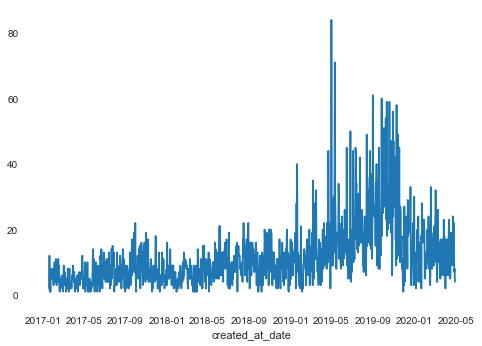

In [386]:
#check if there a times where no data is available 
twitterdata_timeseries = twitterdata.groupby("created_at_date").count().loc[:,"retweet_count"]
twitterdata_timeseries.plot()

Seems like there are no relevant timeperiods without tweets. 

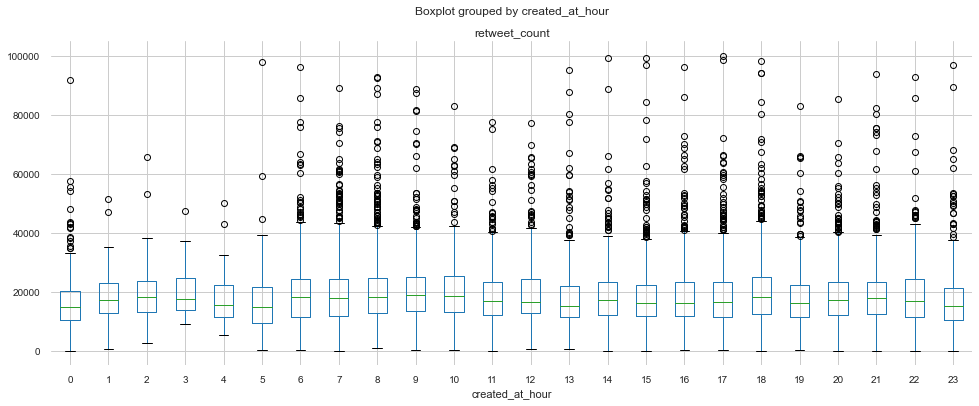

In [387]:
#check if time of the day is relevant feature
twitterdata_source_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_hour', figsize = (16,6))

There a no immense differences but small changes. Therefore the values are binned into times of day.

In [388]:
#create feature times of day
twitterdata["created_at_daytime"] = pd.cut(twitterdata['created_at_hour'],[0,6,12,18,24], labels = ['Night', 'Morning', 'Afternoon', 'Evening'],include_lowest=True).cat.codes

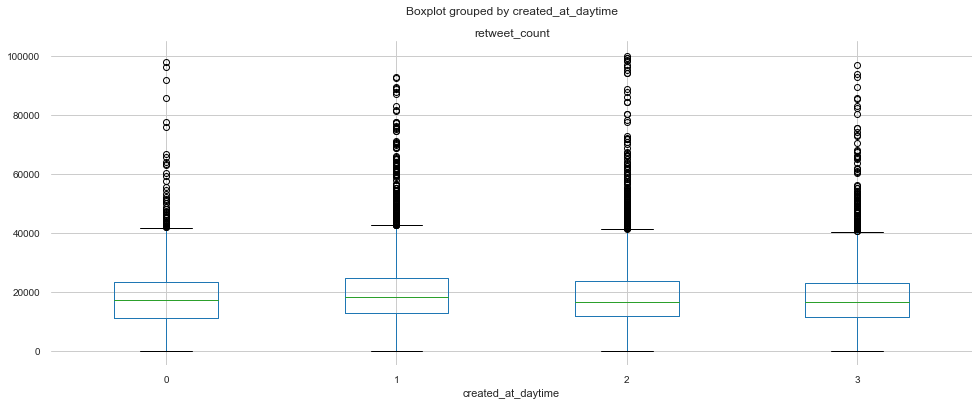

In [389]:
#show impact of feature times of day
twitterdata_source_daytime_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_daytime', figsize = (16,6))

In [390]:
#create feature day of the week
twitterdata["created_at_weekday"] = twitterdata["created_at"].dt.day_name().astype('category').cat.codes

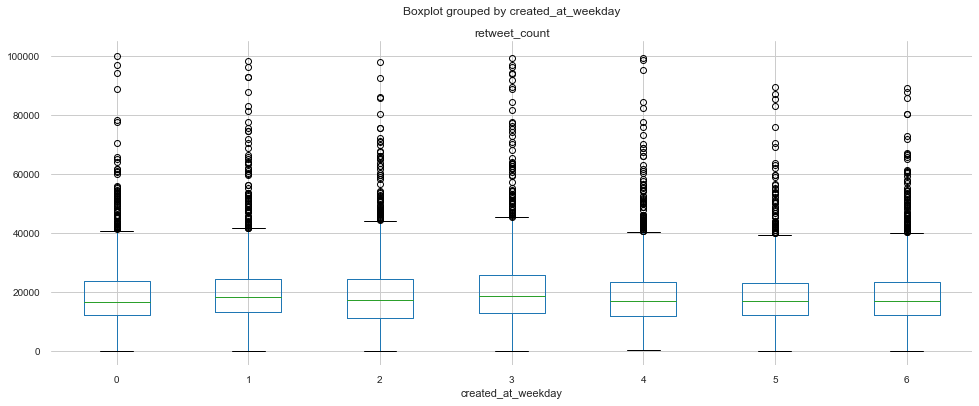

In [391]:
#show impact of feature day of the week
twitterdata_source_weekday_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by='created_at_weekday', figsize = (16,6))

In [392]:
#create feature month
twitterdata["created_at_month"] = twitterdata["created_at"].dt.month.astype('category').cat.codes

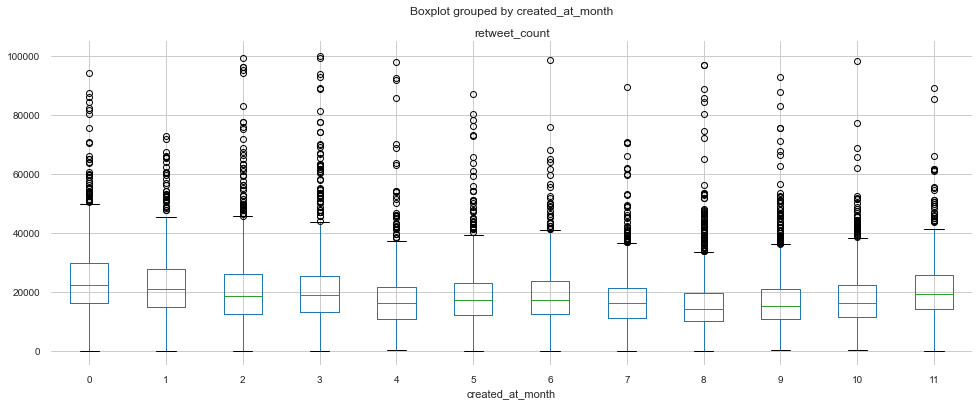

In [393]:
#show impact of feature month
twitterdata_source_month_boxplot = twitterdata[twitterdata["retweet_count"] < 100000].boxplot(column='retweet_count', by= 'created_at_month', figsize = (16,6))

In [394]:
#create feature age of the tweet in days
from pytz import timezone
from datetime import datetime
date_inaguration = datetime(2017, 1, 20, 0, 0, 1).astimezone(timezone("America/New_York")) #the date Trump was inaugurated
twitterdata['created_at_age_days'] = (twitterdata['created_at'] - date_inaguration).dt.days
twitterdata['created_at_age_months'] = round((twitterdata['created_at'] - date_inaguration).dt.days/30,0)

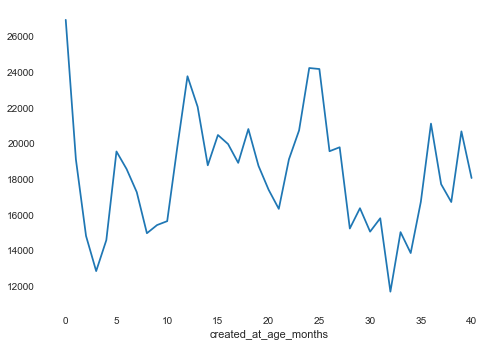

In [395]:
#plot the development of retweets median per month
twitterdata.groupby("created_at_age_months").median()["retweet_count"].plot.line()

Seems like this will be a good feature later.

In [396]:
twitterdata = twitterdata.drop(["created_at","created_at_utc","created_at_date","created_at_age_months"], axis=1)

In [397]:
twitterdata.head()

,text,retweet_count,id_str,source_binned,created_at_hour,created_at_daytime,created_at_weekday,created_at_month,created_at_age_days
0,"No, I think Amash would make a wonderful candi...",14918,1255510996623527936,1,10,1,6,3,1195
1,THANK YOU @MarkLevinShow! \nhttps://t.co/GJSNM...,22235,1255507868280856576,1,10,1,6,3,1195
2,At least they admit it. The Failing @nytimes &...,22881,1255484391364665344,1,9,1,6,3,1195
3,The only reason the U.S. has reported one mill...,43268,1255352014042738688,1,0,0,6,3,1195
4,THANK YOU MICHAEL! @bittyandbeaus https://t.co...,17471,1255325711960768512,1,22,3,5,3,1195


### Check the attribute  id_str  
This is represented in the data as integer (integer64).

In [398]:
#check if this is a unique identifier
if twitterdata["id_str"].nunique() == twitterdata.shape[0]:
    print("This is a unique identifier.")

This is a unique identifier.


In [399]:
#drop id_str
twitterdata = twitterdata.drop("id_str", axis = 1)

It is not needed anymore.

### Check the attribute text 
This is represented in the data as strings (object).

In [400]:
#short summary of the attribute
twitterdata['text'].describe()

count                         13796
unique                        13638
top       MAKE AMERICA GREAT AGAIN!
freq                             22
Name: text, dtype: object

The topic of duplicated entries was already discussed before. 

Now it needs to be understood how the strings are decoded and and how
* videos
* smiley
* hashtags
* mentions
* urls
* images

are stored

#### Video 
All tweets by Twitter Media Studio or Media Studio contain self hosted videos.These are already included as feature in source_binned.

#### Smileys
Smiley will be taken as feature trough the tokenization. A next step would be to check the meaning of the smileys and order them into a new category.

####  Hashtags
Extract hastages with regex. Will be implemented in a function to make it possible to include it in cross-validation.

In [401]:
#extract hashtags
import re
#define function to get hashtags
def hashtags(text):
    pattern = re.compile(r"#(\w+)")
    hashtags = pattern.findall(text)
    return hashtags

#apply to dataset
twitterdata['hashtag_content'] =  twitterdata.apply(lambda x: hashtags(x['text']), axis=1)

#if tweet contains hashtag (boolean)
twitterdata['hashtag_included'] =  twitterdata.apply(lambda x: int(len(x['hashtag_content']) > 0) , axis=1)

# number of hashtags
twitterdata['hashtag_number'] =  twitterdata.apply(lambda x: len(x['hashtag_content']), axis=1)

In [402]:
#define function build dictionary to search for most used hashtags 
def create_dictionary_hashtags(data):
    dictionary_hashtags = {} #initialize empy dictionary

    #build dictionary
    for i in data.index:
        tweet_text = data['text'][i]
        tweet_text_tokenized = tweet_text.split()
    
        #check for hashtags
        for word in tweet_text_tokenized:
            if (word[0:1] == '#' and len(word) > 1):
                if word in dictionary_hashtags:
                    dictionary_hashtags[word] += 1
                else:
                    dictionary_hashtags[word] = 1

    #transform to dataframe
    dataframe_hashtags = pd.DataFrame(dictionary_hashtags.items(), columns=['Hashtag', 'occurences'])
    
    #return dataframe
    return dataframe_hashtags

In [403]:
#build dictionary to search for most used hastags 
dataframe_hashtags = create_dictionary_hashtags(twitterdata)

In [404]:
#analyze dataframe
print("There are " + str(dataframe_hashtags.shape[0]) + " different hashtags.")
dataframe_hashtags.sort_values("occurences", ascending = False).head(n = 10)

There are 717 different hashtags.


,Hashtag,occurences
1,#MAGA,168
21,#KAG2020,58
56,#MAGA🇺🇸,31
525,#USA🇺🇸,23
183,#Dorian,17
116,#1,15
27,#KAG,15
147,#FakeNews,14
167,#UNGA,13
10,#2A.,12


In [405]:
twitterdata = twitterdata.drop("hashtag_content", 1)

Since the goal is to have a generalizable model, which extract actionable knowledge Hashtags with occurences smaller than  will be ignored. The rest will be extracted and added as a feature.

A next possible step is to bin the hashtags in different categories. This is out of scope of this project.

#### Mentions
Extract mentions with regex.

In [406]:
#extract mentions
#define function to get mentions
def mentions(text):
    pattern = re.compile(r"@(\w+)")
    mentions = pattern.findall(text)
    return mentions

#apply to dataset
twitterdata['mentions_content'] =  twitterdata.apply(lambda x: mentions(x['text']), axis=1)

#if tweet contains hashtag (boolean)
twitterdata['mentions_included'] =  twitterdata.apply(lambda x: int(len(x['mentions_content']) > 0) , axis=1)

# number of hashtags
twitterdata['mentions_number'] =  twitterdata.apply(lambda x: len(x['mentions_content']), axis=1)

In [407]:
#define function build dictionary to search for most used mentions
def create_dictionary_mentions(data):
    dictionary_mentions = {} #initialize empy dictionary

    #build dictionary
    for i in data.index:
        tweet_text = data['text'][i]
        tweet_text_tokenized = tweet_text.split()
    
        #check for hashtags
        for word in tweet_text_tokenized:
            if (word[0:1] == '@' and len(word) > 1):
                if word in dictionary_mentions:
                    dictionary_mentions[word] += 1
                else:
                    dictionary_mentions[word] = 1

    #transform to dataframe
    dataframe_mentions = pd.DataFrame(dictionary_mentions.items(), columns=['Mentions', 'occurences'])
    
    #return dataframe
    return dataframe_mentions

In [408]:
#build dictionary to search for most used mentions
dataframe_mentions = create_dictionary_mentions(twitterdata)

In [409]:
#analyze dataframe
print("There are " + str(dataframe_mentions.shape[0]) + " different mentions.")
dataframe_mentions.sort_values("occurences", ascending = False).head(n = 15)

There are 1905 different mentions.


,Mentions,occurences
11,@FoxNews,261
306,@realDonaldTrump:,232
323,@realDonaldTrump,225
26,@foxandfriends,208
322,@WhiteHouse:,158
397,@GOPChairwoman:,77
87,@WhiteHouse,76
254,@dbongino,64
93,@LouDobbs,58
1,@nytimes,58


Since the goal is to have a generalizable model, which extract actionable knowledge menntions with occurences of less than a treshold. will be ignored.

In [410]:
twitterdata = twitterdata.drop("mentions_content", 1)

A possible next step is to cluster the different mentioned users into groups like Republicans and Democrat. This is out of scope of this project.

#### Urls
Extract urls.

In [425]:
#extract urls
#define function to get urls
def urls(text):
    pattern = re.compile(r"http\S+")
    urls_content = pattern.findall(text)
    return urls_content

#apply to dataset
twitterdata['urls_content'] =  twitterdata.apply(lambda x: urls(x['text']), axis=1)

#if tweet contains url (boolean)
twitterdata['urls_included'] =  twitterdata.apply(lambda x:  int(len(x['urls_content'])) > 0 , axis=1)

In [426]:
#build dictionary to search for most used urls
dictionary_urls = {} #initialize empy dictionary

#build dictionary
for i in twitterdata.index:
    tweet_text = twitterdata['text'][i]
    tweet_text_tokenized = tweet_text.split()
    
    #check for hashtags
    for word in tweet_text_tokenized:
        if (word[0:4] == 'http'):
            if word in dictionary_urls:
                dictionary_urls[word] += 1
            else:
                dictionary_urls[word] = 1

#transform to dataframe
dataframe_urls = pd.DataFrame(dictionary_urls.items(), columns=['Mention', 'occurences'])

In [427]:
#analyze dataframe
print("There are " + str(dataframe_urls.shape[0]) + " different urls.")
dataframe_urls.sort_values("occurences", ascending = False).head(n = 5)

There are 4172 different urls.


,Mention,occurences
2635,https://t.co/0pWiwCHGbh,17
1475,https://t.…,10
990,https://…,9
1129,https://t.c…,8
2681,https://t.co/0pWiwCq4MH,8


Seems like there is no real frequent urls. Therefore they will not be used further. A next possible step would be to check if the content of the urls contains valuable information. This is out of scope of this project.

In [430]:
twitterdata = twitterdata.drop("urls_content", 1)

KeyError: "['urls_content'] not found in axis"

#### Images
Images could be possible detected by analysis of the url. This is out of scope for this project.

#### Text feature creation
From the text there are many possibilities to create features.

In [416]:
#create feature length of tweets
twitterdata["text_lenght"] = twitterdata["text"].apply(len)

In [439]:
# replace url with "url"
def replace_urls(text):
    return re.sub(r"http\S+", "url", text)

#create feature includes numbers
twitterdata["numbers_contained"] = twitterdata.apply(lambda x: replace_urls(x['text']), axis=1).apply(lambda x : any(char.isdigit() for char in x)).astype(int)

In [469]:
#create function find capslocked words
def is_uppercase(text):
    result = 0
    for word in text.split():
        if word.isupper() == True and len(word) > 1:
            result = 1
            break
    return result
    
#create feature includes word in capslock
twitterdata["capslock_contained"] = twitterdata.apply(lambda x: is_uppercase(x['text']), axis=1)

#### Preprocess text

Define function which preprocess the text

In [474]:
#remove urls 
def remove_urls(text):
    return re.sub(r"http\S+", '', text)

In [475]:
#remove hashtags with words
def remove_hashtags(text):
    return re.sub(r"#+", '', text)

In [476]:
#remove mentions with words
def remove_mentions(text):
        return re.sub(r"@+", '', text)

In [477]:
# remove punctuation
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        if punctuation != '!': # leave exclamation mark
            text = text.replace(punctuation, '')
    return text

In [478]:
#remove numbers 
def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

In [479]:
#remove special characters
def remove_special(text):
    for char in ['€','�','‡','†','‰','™','•','–', '—',]:
        text = text.replace(char, '')
    return text

In [480]:
#make word lowercase
def lower_case(text):
    for word in text.split():
         word.lower()
    return text

#### Lemmatization text

In [541]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
#nltk.download('wordnet')
#nltk.download('punkt')

def lemmatize_text(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for word in text.split():
        lemmatized_text.append(wordnet_lemmatizer.lemmatize(word,pos="v"))
    return " ".join(lemmatized_text)

In [548]:
#apply lemmatization
twitterdata["text"] = twitterdata.apply(lambda x : lemmatize_text(x["text"]), axis = 1)

--- 2.270236015319824 seconds ---


## Feature selection

Steps taken are:
* took hashtags only with treshold amount of appearances
* took mentions only with treshold amount of appearances
* took words only with treshold amount of appearances
* select features based on kendall correlation measure


In [330]:
#create function for hashtag feature generation
def generate_feature_hashtag(treshold, data): 
    
    #generate hashtag dictionary
    data['hashtag_content'] = data.apply(lambda x: hashtags(x['text']), axis=1)
    dataframe_hashtags = create_dictionary_hashtags(data)
    index_threshold = dataframe_hashtags[dataframe_hashtags["occurences"] > treshold]["Hashtag"]
    
    for index, value in index_threshold.items():
        data[str(value)] = data['text'].str.contains(re.compile(value))
    
    data_feature_added = data.drop("hashtag_content", 1)
    
    #return dataset with added feature
    return data_feature_added

In [335]:
#create function for mentions feature generation
def generate_feature_mentions(treshold, data): 
    
    #generate mentions dictionary
    data['mention_content'] = data.apply(lambda x: mentions(x['text']), axis=1)
    dataframe_mentions = create_dictionary_mentions(data)
    index_threshold = dataframe_mentions[dataframe_mentions["occurences"] > treshold]["Mentions"]
    
    for index, value in index_threshold.items():
        data[str(value)] = data['text'].str.contains(re.compile(value))
    
    data_feature_added = data.drop("mention_content", 1)
    
    #return dataset with added feature
    return data_feature_added

#### Tokenize

In [482]:
#function than combines the preprocessings
def preprocess_text(text):
    
    #remove urls
    text = remove_url(text)
    
    #remove hashtags
    text = remove_hashtags(text)
    
    #remove mentions
    text = remove_mentions(text)
    
    #remove punctuations
    text = remove_punctuations(text)
    
    #remove number
    text = remove_numbers(text)
    
    #remove special characters
    text = remove_special(text)
    
    #turn to lower
    text = lower_case(text)
    
    return text

In [551]:
#simple count vektorizing
from sklearn.feature_extraction.text import CountVectorizer

    
#define function for Vectorizing and Stemming
def vectorize_stemming(data,min_df):
    
    #lemmatize

    #vectorize
    vectorizer = CountVectorizer(analyzer = 'word', stop_words = "english", min_df = min_df, binary = True) #remove stopwords and words with frequency of less than 100 appearances
    document_term = pd.DataFrame(vectorizer.fit_transform(data['text']).toarray(), columns = vectorizer.get_feature_names())
    
    #combine data sets
    data_enriched = pd.concat([data, document_term], ignore_index=False, sort =False, axis=1)
    data_enriched = data_enriched.drop("text", 1)
    
    return data_enriched

It would be possible to work even more with the text and use thing like uppercase as a feature. Further methods like embeddings and furhter preprocessing could be applied to improve results. This is out of scope of this project.

#### Mutual information criterion
The mutual information criterion is used to subset the features.

In [355]:
#create function for feature subset selection
def feature_selection_kendall_measure(data, treshold):
        
        mutual_information = data.corrwith(data["retweet_count"], method='kendall')
        mutual_information_abs = mutual_information.abs()
        data_train_feature_selected = data.iloc[:, (mutual_information_abs >= treshold).values]
        
        return data_train_feature_selected

Further steps could be taken. This is out of scope for this project.

## Model building

In [351]:
#split in training and test
twitterdata_train = twitterdata_enriched.sample(frac=0.8,random_state=200) 
twitterdata_test = twitterdata_enriched.drop(twitterdata_train.index)

In [ ]:
#prepare train and test set for model building
X_train = twitterdata_train.drop("retweet_count", axis = 1).values
y_train = twitterdata_train["retweet_count"].values

### Build pipeline

### Linear Regression (Baseline)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

estimator = LinearRegression()
time_diff = X_train[:, -1].reshape(-1, 1)
baseline_scores = cross_val_score(estimator, time_diff, \
                         y_train, cv=20, scoring='neg_mean_squared_error')

baseline_score = -np.mean(baseline_scores)

print('Mean squared Error:', round(np.mean(baseline_score), 2))

In [ ]:
estimator = LinearRegression()
baseline_scores_abs = cross_val_score(estimator, time_diff, y_train, cv=20, scoring='neg_mean_absolute_error')
baseline_score_abs = -np.mean(baseline_scores_abs)

print('Mean absolute Error:', round(np.mean(baseline_score_abs), 2))

In [ ]:
def validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, scoring):
    train_scores, test_scores = validation_curve(estimator, X_train, y_train, parameter, param_range, cv=cv, scoring = scoring)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with Ridge Regression")
    plt.xlabel(parameter)
    plt.ylabel("Metric")

    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)

    errors_baseline_plot = np.ones(param_range.shape) * baseline_score_abs
    plt.plot(param_range, errors_baseline_plot, label = "Baseline")

    plt.legend(loc="best")
    plt.show()

def plot_learning_curve(estimator, title, X, y, scoring, baseline_scr, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring = scoring,
                       return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    

    # Plot learning curve
    axes[0].grid()
    errors_baseline_plot = np.ones(train_sizes.shape) * baseline_scr
    axes[0].plot(train_sizes, errors_baseline_plot, label = "Baseline")
    
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import validation_curve

estimator = Ridge()
param_range = np.logspace(-3, 3, 6)
scoring = make_scorer(mean_absolute_error)
parameter = "alpha"
cv = 3
validation_curve_function(estimator, X_train, y_train, parameter, param_range, cv, scoring)

In [ ]:
from sklearn.model_selection import learning_curve
title = "Learning Curves (Ridge Regression)"

cv = 5
scoring = make_scorer(mean_absolute_error)

estimator = Ridge(alpha = 1)
plot_learning_curve(estimator, title, X_train, y_train, scoring, baseline_score_abs, cv=cv, n_jobs=4)

plt.show()

### Lasso Regression

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
title = "Learning Curves (Random Forest)"

cv = 3
scoring = make_scorer(mean_absolute_error)
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train, y_train, scoring, baseline_score_abs, cv=cv, n_jobs=4)

plt.show()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

best_random = rf_random.best_estimator_


predictions = best_random.predict(X_test)
errors =  mean_squared_error(predictions, y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

### GA2Ms

### Hyperparameter tuning

## Feature importance

SHAP

In [ ]:
import shap
# shap comes with pre-built explainers for pretty much any model
# important: ONLY pass training data to explainer!
exp = shap.TreeExplainer(l, x_train)

In [ ]:
# load JS visualization code to notebook and showcase what changed a single prediction
shap.initjs()
shap.force_plot(exp.expected_value, shap_vals[0,:], x_test.iloc[0,:])

## Results

How good is the result? Which variables are important?

In [358]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_above()'))

<IPython.core.display.Javascript object>

In [352]:
from pandas_profiling import ProfileReport
profile = ProfileReport(twitterdata_train, explorative=True, minimal=True, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()